# High Performance Computing Systems

Before we go into some parallel programming with Julia, let's take a look at what a distributed High Performance Computing (HPC) system looks like.

The intention for a HPC system is scale. Rather than scaling up for a single user by getting a better computer with more RAM, cores, etc (vertical scaling), an HPC system scales by combining a large number of machines that can be used by many users (horizontal scaling).

Each machine in a distributed system is called a node. Most of the nodes are called "compute nodes", where the computational work gets done. There are few other nodes that have specialized tasks. The login node is where users log in to launch jobs. The scheduler node runs the scheduler, which is the software that allocates resources through which users launch jobs. The monitoring system keeps track of what is going on with the system. There is a shared file system that all compute nodes can see, so you don't have to worry about your data getting lost on some node's local file system, and a big switch that connects everything together. The LAN switch connects the system to the internet, so users can connect to it from their desktops and laptops.

<img src="images/MITSupercloud.png" alt="Drawing" style="height: 300px;"/>

# Helper Functions and Stopwords

This file contains a variable with a list of stopwords- words that will be removed and left out of the word count.

In [19]:
using Statistics
include("../word_count_helpers.jl")

countwords (generic function with 1 method)

The cleantext function prepares text for word counting. It takes in the full text and removes punctuation, extra whitespace, and stopwords. Also converts all text to lowercase.

```julia
function cleantext(text)
    
    # Get full text without whitespace, punctuation, or stopwords
    idx = findall(occursin.("***",text))
    text = text[idx[1]+1:idx[2]-1]
    text = replace(join(text[text.!=""]," "),r"\p{P}|[0-9]" => " ")
    text = lowercase(replace(text, r"\s{2,}" => " "))

    for w in stopwords
        text = replace(text," "*w*" " => " ");
    end

    return text
end
```

The countwords function computes the number of times each word appears in the text. It takes in the cleaned text, and ouputs a dictionary of word counts.

```julia
function countwords(text)
    textSep = split(text," ")
    wordcounts = Dict{String,Float64}()
    for w in textSep
        wordcounts[w] = get(wordcounts, w, 0) + 1
    end
    
    return wordcounts
end
```

# Calculate Word Counts Serially

Before jumping straight into parallel implementations, it is important to first make sure you have working, efficent serial code. Code that does not run well in serial will not run well in parallel.

First we are going to calculate the word counts for each book, and output the top five for each book.

In [20]:
# Load the file names
dataLoc = "../../../data/word_count/";
fnames = dataLoc.*readdir(dataLoc)

# Iterate through file names
for i = 1:length(fnames)

    # Read in file and clean the text
    text = readlines(fnames[i])
    text = cleantext(text,stopwords)

    # Count number of times each word appears
    wordCounts = countwords(text)

    # Sort and print the top 5 words with their counts
    rankedwords = sort(collect(wordCounts), by=x->x[2], rev=true)
    println(rankedwords[1:5,:])
    
end


Pair{String,Float64}["cavor" => 302.0; "moon" => 212.0; "time" => 173.0; "sphere" => 127.0; "earth" => 119.0]
Pair{String,Float64}["world" => 233.0; "men" => 178.0; "king" => 177.0; "man" => 176.0; "time" => 131.0]
Pair{String,Float64}["man" => 214.0; "montgomery" => 205.0; "moreau" => 144.0; "beast" => 109.0; "men" => 101.0]
Pair{String,Float64}["room" => 35.0; "candle" => 21.0; "door" => 18.0; "man" => 17.0; "hand" => 13.0]
Pair{String,Float64}["time" => 201.0; "machine" => 86.0; "man" => 70.0; "traveller" => 61.0; "white" => 59.0]
Pair{String,Float64}["martians" => 164.0; "people" => 159.0; "man" => 126.0; "time" => 122.0; "black" => 122.0]
Pair{String,Float64}["man" => 260.0; "kemp" => 245.0; "mr" => 223.0; "invisible" => 181.0; "door" => 171.0]
Pair{String,Float64}["veronica" => 731.0; "ann" => 715.0; "life" => 208.0; "man" => 194.0; "love" => 188.0]
Pair{String,Float64}["graham" => 580.0; "man" => 355.0; "people" => 275.0; "men" => 207.0; "ostrog" => 187.0]
Pair{String,Float64}["

Now we are going to find the top five overall word counts.

In [21]:
function getwordcounts(fname)
    # Read in file and clean the text
    f = open(fname)
    text=cleantext(readlines(f))

    # Count number of times each word appears
    return countwords(text)
end

# Get counts for each book
allcounts = getwordcounts.(fnames)

# Calculate the overall word counts
overallcounts = merge(+,allcounts...)

# Sort and print the top 5 words with their counts
println(sort(collect(overallcounts), by=x->x[2], rev=true)[1:5,:])

Pair{String,Float64}["man" => 1996.0; "time" => 1617.0; "mr" => 1527.0; "people" => 1128.0; "world" => 1119.0]


Now we are going to get the top five words for each book, normalized by the overall count.

In [22]:
# Get counts for each book
allcounts = getwordcounts.(fnames)

# Calculate the overall word counts
overallcounts = merge(+,allcounts...)

# Iterate through each set of word counts
for counts in allcounts

    # Calculate normalized score
    thresh = quantile(collect(values(counts)), .98)
    counts = filter!(word-> word.second > thresh, counts)
    normscore = merge(/,counts,filter(word->haskey(counts,word.first), overallcounts))

    # Sort and print the top 5 words with their normalized counts
    rankedwords = sort(collect(normscore), by=x->x[2], rev=true)
    println(rankedwords[1:min(5,length(counts)),:])
end

Pair{String,Float64}["cavorite" => 1.0; "mooncalf" => 1.0; "lunar" => 1.0; "cavor" => 1.0; "selenites" => 1.0]
Pair{String,Float64}["leblanc" => 1.0; "holsten" => 1.0; "fowler" => 1.0; "brissago" => 1.0; "karenin" => 1.0]
Pair{String,Float64}["montgomery" => 1.0; "puma" => 1.0; "moreau" => 1.0; "prendick" => 1.0; "swine" => 0.9642857142857143]
Pair{String,Float64}["withered" => 0.6923076923076923; "candles" => 0.6190476190476191; "candle" => 0.5675675675675675; "shade" => 0.2962962962962963; "room" => 0.06862745098039216]
Pair{String,Float64}["psychologist" => 1.0; "morlocks" => 1.0; "weena" => 1.0; "filby" => 1.0; "sphinx" => 1.0]
Pair{String,Float64}["artilleryman" => 1.0; "ulla" => 1.0; "martian" => 1.0; "woking" => 1.0; "martians" => 0.9939393939393939]
Pair{String,Float64}["henfrey" => 1.0; "adye" => 1.0; "mariner" => 1.0; "griffin" => 1.0; "jaffers" => 1.0]
Pair{String,Float64}["vee" => 1.0; "ann" => 1.0; "alice" => 1.0; "miniver" => 1.0; "veronica" => 1.0]
Pair{String,Float64}["

# Throughput Parallel Programming

The first and simplest parallel programming model is sometimes called "Throughput" or "Pleasantly Parallel" (you may have heard "Embarassingly Parallel" as well). It requires no communication between processes, and no aggregation of results. The biggest clue that you have something that can be considered Throughput is if you have a for loop, where no iteration depends on the one before it, and little or no work to do after it.

In our first example, we are interating through a number of files, calculating something and outputing something for each file. Our other examples we have to do a bit more, they require some amount of communication between processes.

<img src="images/Throughput.png" alt="Throughput" style="height: 200px;"/>

Julia supports a Leader-Worker programming model, which is fairly intuitive for those new to paralell programming. There is a lead process, in this case the process attached to this Jupyter notebook, and several worker processes which you can add using the "addprocs" command. Since this notebook is running on a 16 core machine, I am adding 15 workers. If you are running this on your computer, you don't want to set this higher than the number of cores on your computer. You can see the number of workers by running the "nworkers" function.

In [23]:
using Distributed

set_workers = 3

if nworkers() < set_workers
    addprocs(set_workers-(nprocs()-1))
    
end

nworkers()

3

You can think of each worker process as a fresh Julia session that takes instruction from the leader process. Therefore, they each have their own memory space, so any variables or functions that have been defined on the leader process are not available on the worker processes. You can define a function on variable on all running processes by using the @everywhere macro.

Why let each worker have access to the same memory space? This is fine if you are working on a single machine, however if you want to scale across several machines, this will not work. Julia enforces this scalability from the beginning.

I've included the cleantext and countwords functions in the helpers.jl file so we can easily load them into all processes.

In [24]:
@everywhere begin
    using DistributedArrays,Statistics
    include("../Parallel/parallelhelpers.jl")
end

We are going to use Julia's Distributed Arrays package to do our parallel processing. This package works by creating arrays where each index of the array is assigned to a particular process. In this case, we are going to distribute the array of filenames. We can see which indices are assigned to which process by looking at the indices field of dfnames.

In [25]:
using DistributedArrays

dfnames = distribute(fnames)
dfnames.indices

3-element Array{Tuple{UnitRange{Int64}},1}:
 (1:5,)  
 (6:9,)  
 (10:13,)

One of the easiest ways to use distributed arrays, especially in a throughput context, is to use the broadcast operator. To do this, we need to define a function that executes a single iteration of the original for loop.

In [26]:
@everywhere function getcounts(fname)
    
    # Read in file and clean the text
    text = readlines(fname)
    text = cleantext(text,stopwords)
    
    # Count number of times each word appears
    wordcounts = countwords(text)
    
    # Sort and print the top 5 words with their counts
    rankedwords = sort(collect(wordcounts), by=x->x[2], rev=true)
    println(rankedwords[1:5,:])
    
    return wordcounts
end

And now we can call getcounts on each element of the Distributed Array. The broadcast operator combined with the distributed array takes care of where each file gets processed, so you don't have to worry about that. The result is another distributed array with the result. (Run twice- the first time includes the compile time for the functions)

In [27]:
@time allCounts = getcounts.(dfnames);

      From worker 3:	Pair{String,Float64}["martians" => 164.0; "people" => 159.0; "time" => 122.0; "black" => 122.0; "brother" => 104.0]
      From worker 2:	Pair{String,Float64}["cavor" => 302.0; "moon" => 212.0; "time" => 173.0; "sphere" => 127.0; "earth" => 119.0]
      From worker 4:	Pair{String,Float64}["bert" => 616.0; "time" => 228.0; "air" => 206.0; "great" => 165.0; "world" => 155.0]
      From worker 3:	Pair{String,Float64}["kemp" => 245.0; "mr" => 223.0; "invisible" => 181.0; "door" => 171.0; "hall" => 160.0]
      From worker 2:	Pair{String,Float64}["world" => 233.0; "king" => 177.0; "time" => 131.0; "great" => 127.0; "life" => 101.0]
      From worker 4:	Pair{String,Float64}["redwood" => 325.0; "bensington" => 210.0; "cossar" => 174.0; "food" => 174.0; "great" => 161.0]
      From worker 4:	Pair{String,Float64}["red" => 102.0; "slim" => 71.0; "industrialist" => 42.0; "astronomer" => 41.0; "animals" => 30.0]
      From worker 2:	Pair{String,Float64}["montgomery" => 205.0; "

In [28]:
@time getcounts.(fnames); # run this twice

Pair{String,Float64}["cavor" => 302.0; "moon" => 212.0; "time" => 173.0; "sphere" => 127.0; "earth" => 119.0]
Pair{String,Float64}["world" => 233.0; "king" => 177.0; "time" => 131.0; "great" => 127.0; "life" => 101.0]
Pair{String,Float64}["montgomery" => 205.0; "moreau" => 144.0; "beast" => 109.0; "face" => 89.0; "eyes" => 88.0]
Pair{String,Float64}["room" => 35.0; "candle" => 21.0; "door" => 18.0; "hand" => 13.0; "red" => 13.0]
Pair{String,Float64}["time" => 201.0; "machine" => 86.0; "traveller" => 61.0; "white" => 59.0; "felt" => 57.0]
Pair{String,Float64}["martians" => 164.0; "people" => 159.0; "time" => 122.0; "black" => 122.0; "brother" => 104.0]
Pair{String,Float64}["kemp" => 245.0; "mr" => 223.0; "invisible" => 181.0; "door" => 171.0; "hall" => 160.0]
Pair{String,Float64}["veronica" => 731.0; "ann" => 715.0; "life" => 208.0; "love" => 188.0; "time" => 185.0]
Pair{String,Float64}["graham" => 580.0; "people" => 275.0; "ostrog" => 187.0; "council" => 153.0; "great" => 149.0]
Pair{S

# Map Reduce

When most people hear Map Reduce, they usually think Hadoop, Java, Big Data, etc. Map Reduce is actually a parallel programming model that has been around for a long time. It consists of two steps: a map step where an operation is executed on a number of files in paralell (like the throughput example we just talked about), and a reduce step where the output of the map step is combined into a single output.

In our word count example, the top 5 overall word counts is a good example of a problem that fits the Map Reduce paradigm. Getting the individual word counts of each book is the Map step, and combining the individual word counts is the Reduce step.

<img src="images/MapReduce.png" alt="Map Reduce" style="height: 250px;"/>

With Julia's Leader-Working model, this is pretty easy to do. The map step is done by the workers, the result is gathered on the local leader process, and the reduce step is done by the leader process.

In [29]:
# Just redefining getcounts without the println statements
@everywhere function getcounts_quiet(fname)
    
    # Read in file and clean the text
    text = readlines(fname)
    text = cleantext(text,stopwords)
    
    # Count number of times each word appears
    wordcounts = countwords(text)
    
    return wordcounts
end

# This is the Map step
@time allcounts = getcounts_quiet.(dfnames)
allcounts_local = convert(Array,allcounts)

# Reduce Step: Merge the counts from all files
overallcounts = merge(+,allcounts_local...)

# Sort and print the top 5 words with their counts
println(sort(collect(overallcounts), by=x->x[2], rev=true)[1:5,:])

  1.438300 seconds (249.78 k allocations: 12.991 MiB)
Pair{String,Float64}["time" => 1617.0; "mr" => 1527.0; "people" => 1128.0; "world" => 1119.0; "back" => 989.0]


# More Complex Parallel

There is a lot of flexibility in how you can write a parallel program. It can be a bit overwhelming, but you start by identifying which steps can be done in parallel and where communication needs to happen. In the earlier examples this wasn't too hard, and you can move to a more complex problem by looking for the same patterns.

There is no single right way to write a parallel program. It depends on the data and opeartions you are running. In this section, I'll go over three different ways to tackle the normalized word count problem. For fun, we'll time everything and make a nice plot at the end so we can see how much time is spent in each step and in communication.

There are three steps to doing the normalized word count. We will need a function for each.

In [30]:
# getcounts opens the the file passed in, cleans the text, and calls countwords
@everywhere function getcounts(fname)
    f = open(fname)
    text = cleantext(readlines(f),stopwords)
    return countwords(text)
end

# getglobalcount takes in an array of counts and merges them to get the overall count
@everywhere function getoverallcount(counts)
    return merge(+,counts...)
end

# getnormcount takes the a dictionary of counts, grabs the previously defined global count, and calculates the normalized count  
@everywhere function getnormcount(counts,overallcounts)
    # Calculate normalized score
    thresh = quantile(collect(values(counts)), .98)
    filteredcounts = filter!(word-> word.second > thresh, counts)
    normscore = merge(/,counts,filter(word->haskey(filteredcounts,word.first), overallcounts))

    # Sort and print the top 5 words with their normalized counts
    rankedwords = sort(collect(normscore), by=x->x[2], rev=true)
    println(rankedwords[1:min(5,length(rankedwords)),:])
    return rankedwords
end

## Map Reduce

We can actually formulate normalized word count as a Map Reduce problem, where the reduce step also does the normalization on the leader process.

<img src="images/LooslyCoupled.png" alt="Map Reduce" style="height: 200px;"/>

In [31]:
using BenchmarkTools

In [32]:
# Calculate the word counts
# Broadcast over a distributed array automatically does the operation on the correct worker
allcounts = getcounts.(dfnames)
_,countTime1 = @timed begin
    getcounts.(dfnames)
end

# Collect the distributed array onto the leader process
allcountsL = convert(Array,allcounts)
_,commTime1 = @timed convert(Array,allcounts)

# Calculate the overall counts on the leader
overallcounts = getoverallcount(allcountsL)
_,aggTime1 = @timed getoverallcount(allcountsL)

# Calculate the normalized counts on the leader and print results
normcount = getnormcount.(allcountsL,Ref(overallcounts));
_,normTime1 = @timed getnormcount.(allcountsL,Ref(overallcounts))

countTime1,commTime1,aggTime1,normTime1

Pair{String,Float64}["cavorite" => 1.0; "lunar" => 1.0; "selenites" => 1.0; "phi" => 1.0; "mooncalf" => 1.0]
Pair{String,Float64}["leblanc" => 1.0; "fowler" => 1.0; "brissago" => 1.0; "karenin" => 1.0; "holsten" => 1.0]
Pair{String,Float64}["montgomery" => 1.0; "prendick" => 1.0; "puma" => 1.0; "moreau" => 1.0; "swine" => 0.9642857142857143]
Pair{String,Float64}["withered" => 0.6923076923076923; "candles" => 0.6190476190476191; "candle" => 0.5675675675675675; "shade" => 0.2962962962962963; "room" => 0.06862745098039216]
Pair{String,Float64}["weena" => 1.0; "psychologist" => 1.0; "morlocks" => 1.0; "filby" => 1.0; "sphinx" => 1.0]
Pair{String,Float64}["martian" => 1.0; "artilleryman" => 1.0; "ulla" => 1.0; "woking" => 1.0; "martians" => 0.9939393939393939]
Pair{String,Float64}["henfrey" => 1.0; "adye" => 1.0; "mariner" => 1.0; "griffin" => 1.0; "jaffers" => 1.0]
Pair{String,Float64}["vee" => 1.0; "ann" => 1.0; "alice" => 1.0; "miniver" => 1.0; "veronica" => 1.0]
Pair{String,Float64}["ae

(1.288350153, 0.035092463, 0.009383253, 0.025129262)

## Fork and Join

Another way you can approach this problem is sometimes referred to as a Fork and Join paradigm. It's similar to the Map Reduce approach, however the final step is done in parallel, rather than on the leader process.

<img src="images/ForkJoin.png" alt="Fork and Join" style="height: 200px;"/>

In [33]:
# Calculate the word counts
# Broadcast over a distributed array automatically does the operation on the correct worker
allcountsD = getcounts.(dfnames)
_,countTime2 = @timed getcounts.(dfnames)

# Collect the distributed array onto the leader process
allcountsL = convert(Array,allcountsD)
_,commTime2 = @timed convert(Array,allcountsD)

# Calculate the overall counts on leader process
overallcounts = getoverallcount(allcountsL)
_,aggTime2 = @timed getoverallcount(allcountsL)

# Share the global counts with each of the workers
_,t = @timed @eval @everywhere overallcounts=$overallcounts
commTime2=commTime2+t

# Calculate the normalized counts on each worker
normcount = getnormcount.(allcountsD,Ref(overallcounts));
_,normTime2 = @timed getnormcount.(allcountsD,Ref(overallcounts))

countTime2,commTime2,aggTime2,normTime2

      From worker 3:	Pair{String,Float64}["artilleryman" => 1.0; "ulla" => 1.0; "martian" => 1.0; "woking" => 1.0; "martians" => 0.9939393939393939]
      From worker 3:	Pair{String,Float64}["henfrey" => 1.0; "adye" => 1.0; "mariner" => 1.0; "griffin" => 1.0; "jaffers" => 1.0]
      From worker 3:	Pair{String,Float64}["vee" => 1.0; "ann" => 1.0; "alice" => 1.0; "miniver" => 1.0; "veronica" => 1.0]
      From worker 2:	Pair{String,Float64}["cavorite" => 1.0; "mooncalf" => 1.0; "lunar" => 1.0; "cavor" => 1.0; "selenites" => 1.0]
      From worker 3:	Pair{String,Float64}["graham" => 1.0; "aeropile" => 1.0; "howard" => 1.0; "asano" => 1.0; "isbister" => 1.0]
      From worker 2:	Pair{String,Float64}["leblanc" => 1.0; "holsten" => 1.0; "fowler" => 1.0; "brissago" => 1.0; "karenin" => 1.0]
      From worker 2:	Pair{String,Float64}["montgomery" => 1.0; "puma" => 1.0; "moreau" => 1.0; "prendick" => 1.0; "swine" => 0.9642857142857143]
      From worker 2:	Pair{String,Float64}["withered" => 0.69

(1.279242312, 0.12091094699999999, 0.008811985, 0.021294513)

## SPMD: Single Program Multiple Data

SMPD is a very flexible parallel programming model that is fairly simple, but a little different than the way you might usually think about parallel programming. The idea is you have multiple processes, each with a process ID, and one program that they all run. The data that they run may be different depending on the process, and the processes usually communicate by sending and recieving messages.

Notice in the figure below that each process is executing the same operations in the same order, but often on different data. Specifically, each process is doing the global count step locally. Often the cost of communication makes it worthwhile to the same operation on each process. Here there is a single all-to-all communication step, whereas the Fork and Join example had two (sending the local counts to the leader and sending the global counts to the workers).

This is often the parallel programming model that is used for MPI, or Message Passing Interface, which is one of the most widely used parallel programming tools for high performance and scientific computing.

<img src="images/SPMD.png" alt="SPMD" style="height: 200px;"/>

Since Julia's parallel programming model is Leader-Worker, this isn't true SPMD. However you can get the idea from this example. (Distributed Arrays does also have an SMPD mode)

In [34]:
# Calculate the word counts
# Broadcast over a distributed array automatically does the operation on the correct worker
_,countTime3 = @timed allcounts = getcounts.(dfnames)

# Collect the distributed array onto the leader process and share with workers
_,commTime3 = @timed begin
    allcountsL = convert(Array,allcounts)
    @eval @everywhere allcountsE = $allcountsL
end

# Calculate the overall counts on each woker
_,aggTime3 = @timed @everywhere overallcounts = getoverallcount(allcountsE)

# Calculate the normalized counts on each worker
_,normTime3 = @timed getnormcount.(allcounts,Ref(overallcounts));

countTime3,commTime3,aggTime3,normTime3

      From worker 4:	Pair{String,Float64}["smallways" => 1.0; "edna" => 1.0; "germans" => 1.0; "bert" => 1.0; "butteridge" => 1.0]
      From worker 4:	Pair{String,Float64}["boomfood" => 1.0; "cossar" => 1.0; "hickleybrow" => 1.0; "wondershoot" => 1.0; "herakleophorbia" => 1.0]
      From worker 4:	Pair{String,Float64}["dad" => 1.0; "slim" => 1.0; "industrialist" => 1.0; "explorer" => 0.9565217391304348; "astronomer" => 0.9534883720930233]
      From worker 4:	Pair{String,Float64}["polly" => 1.0; "johnson" => 1.0; "rumbold" => 1.0; "fishbourne" => 1.0; "parsons" => 1.0]
      From worker 3:	Pair{String,Float64}["artilleryman" => 1.0; "ulla" => 1.0; "martian" => 1.0; "woking" => 1.0; "martians" => 0.9939393939393939]
      From worker 3:	Pair{String,Float64}["henfrey" => 1.0; "adye" => 1.0; "mariner" => 1.0; "griffin" => 1.0; "jaffers" => 1.0]
      From worker 2:	Pair{String,Float64}["cavorite" => 1.0; "mooncalf" => 1.0; "lunar" => 1.0; "cavor" => 1.0; "selenites" => 1.0]
      From wo

(1.306100951, 0.158553747, 0.072432951, 0.03485715)

## Comparing Parallel Methods

In [35]:
using Plots,StatsPlots

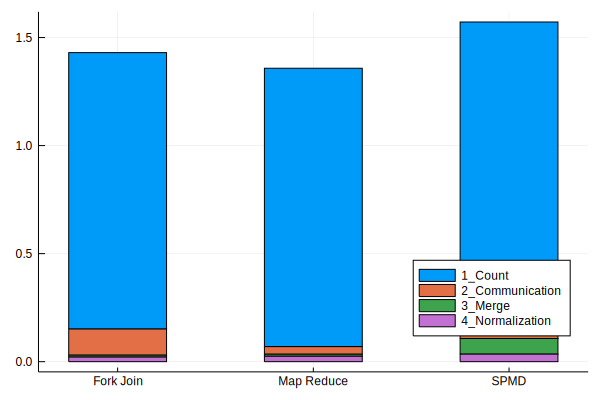

In [36]:
timings = [countTime1 commTime1 aggTime1 normTime1; countTime2 commTime2 aggTime2 normTime2; countTime3 commTime3 aggTime3 normTime3]
names = repeat(["Map Reduce"; "Fork Join"; "SPMD"],4)
labels = repeat(["1_Count", "2_Communication", "3_Merge", "4_Normalization"], inner = 3)
groupedbar(names, timings, group = labels, bar_position = :stack, bar_width=0.5, legend = :bottomright)